### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 3
### Due: Friday, Feb 19th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [1]:
!pip install numdifftools

     |████████████████████████████████| 953 kB 1.8 MB/s eta 0:00:01


### Solution

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats
from scipy import optimize

1.

In [3]:
# import data file
filepath = '../../homeworks/hw_data/hw3_data_1.npy'
data = np.load(filepath)

obs, unc = data[:,0], data[:,1]

In [4]:
sample_mean = np.sum(obs/unc**2)/np.sum(1/unc**2)
sigmax = np.sum(1/unc**2)**-0.5

In [5]:
print('sample mean = ', sample_mean)
print('standard error on sample mean =', sigmax)

sample mean =  3.9179920346060557
standard error on sample mean = 0.09481084100510954


2. 
For the likelihood:

$$L = p(\{x_i\}|\mu,I) = \prod_{i=1}^N \frac{1}{\sigma_i\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}
{2\sigma_i^2}\right).$$

Taking log:

$$\ln L = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma_i^2} = {\rm constant} - \frac{1}{2}\sum_{i=1}^N \chi^2 $$

Maximising $\ln L$ requires minimising $\chi^2$ because constant $>0$

In [6]:
# defining function to search over mu
def chi2(mu, x=obs, sigma=unc):
    # calculating chi2
    return np.sum((x-mu)/sigma)**2

mu0 = 3.
mu_op = optimize.fmin(chi2, mu0)[0]
print(f'\noptimised mu = {mu_op:.3f}')

Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 16
         Function evaluations: 32

optimised mu = 3.928


3.

In [7]:
# creating the likelihood
from scipy.stats import norm

# array of proposed mus
mu_prop = np.linspace(1,5,100)

# array of likelihoods for each mu
L = np.array([np.prod([norm.pdf(obs[i], loc=mu, scale=unc[i]) for i in range(len(obs))]) for mu in mu_prop])

# differentiate twice over mus and sqrt
sigma_mu = np.diff(np.log(L), n=2)
sigma_mu /= (mu_prop[1]-mu_prop[0])**2
sigma_mu *= -1
sigma_mu = 1/np.sqrt(sigma_mu)

print(f"Fisher matrix error on estimated mean: {sigma_mu[0]:.3f}")

Fisher matrix error on estimated mean: 0.095


SRT: Good. If you had any numerical instability problems then in general it's better to work with scipy.stats `.logpdf` attributes, and sum over those.

4. 

In [22]:
np.random.seed()

m = 1000 # number of bootstraps
n = 100 # number of resamples

# bootstrap realisations
def bootstrap(n):
    # random ints to draw from samples
    ints = np.random.randint(0, len(data), n)
    resamples = data[ints]
    
    return resamples

# creating realisations
realisations = np.array([bootstrap(n) for i in range(m)])

5.

In [23]:
mu0 = 3.
mu_op_b = [optimize.fmin(chi2, mu0, args=(realisations[i][:,0], realisations[i][:,1]), disp=False)[0] for i in range(m)]

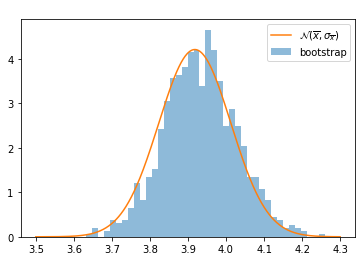

In [24]:
plt.hist(mu_op_b, bins = 40, density=True, alpha=0.5, histtype='stepfilled', label='bootstrap')

xgrid = np.linspace(3.5, 4.3, 1000)
norm_data = norm(loc=sample_mean, scale=sigmax)

plt.plot(xgrid, norm_data.pdf(xgrid), label='$\mathcal{N}(\overline{x}, \sigma_\overline{x})$');
plt.legend(loc='upper right');
plt.annotate(f'n={n}', (3.5,5));

The bootstrap method only agrees if the number of samples in each bootstrap realisation $n=100$. Increasing $n$ reduces the error on the bootstrap method, and so the std dev of the bootstrap samples decreases resulting in a higher, sharper normal distribution.

SRT: OK, I was a bit dubious since your distribution looked a bit offset from the theoretical one. But I unset your random seed to check and everything looks fine.

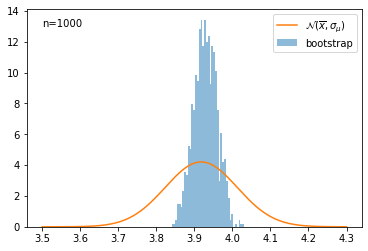

In [248]:
n=1000
realisations2 = np.array([bootstrap(n) for i in range(m)])

mu0 = 3.
mu_op_b2 = [optimize.fmin(chi2, mu0, args=(realisations2[i][:,0], realisations2[i][:,1]), disp=False)[0] for i in range(m)]

plt.hist(mu_op_b2, bins = 40, density=True, alpha=0.5, histtype='stepfilled', label='bootstrap')

xgrid = np.linspace(3.5, 4.3, 1000)
norm_data = norm(loc=sample_mean, scale=sigmax)

plt.plot(xgrid, norm_data.pdf(xgrid), label='$\mathcal{N}(\overline{x}, \sigma_\mu)$');
plt.legend(loc='upper right');
plt.annotate(f'n={n}', (3.5,13));

6.
From wikipedia for Laplacian distribution:

$$ L = \frac{1}{2b}\exp\left(-\frac{|x-\mu|}{b}\right) $$

In [335]:
from scipy.stats import laplace

# array of proposed mus
mu_prop_l = np.linspace(1,5,100)
delta_prop = np.linspace(0.01,2,100)

# array of likelihoods for each proposed mu
lnL = np.array([[np.sum(laplace.logpdf(obs, loc=mu, scale=delta)) for delta in delta_prop] for mu in mu_prop_l])

# finding max lnL
idx_max = np.where(lnL == np.max(lnL))
max_mu_a = mu_prop_l[idx_max[0]][0]
max_delta_a = delta_prop[idx_max[1]][0]

print(f'loc parameter = {max_mu:.3f}\nscale parameter = {max_delta:.3f}')

loc parameter = 4.071
scale parameter = 0.874


SRT: Excellent.

7. $$ \mathrm{AIC}_M \equiv -2\ln[L^0(M)] + 2k + \frac{2k(k+1)}{N-k-1}, $$

In [359]:
lnL_G = np.sum(norm.logpdf(obs, loc=mu_op, scale=sigmax))
lnL_L = np.sum(laplace.logpdf(obs, loc=max_mu, scale=max_delta))

k, N = 2, len(obs)

AIC_G = -2*lnL_G + 2*k + 2*k*(k+1)/(N-k-1)
AIC_L = -2*lnL_L + 2*k + 2*k*(k+1)/(N-k-1)

print(f'AIC for Gaussian: {AIC_G:.3f}\nAIC for Laplace distribution: {AIC_L:.3f}')
print('AIC for Laplace smallest - Laplace is favoured model')

AIC for Gaussian: 14448.533
AIC for Laplace distribution: 317.742
AIC for Laplace smallest - Laplace is favoured model


SRT: Unfortunately not. Your Laplace AIC is fine, but your Gaussian one is off. You should have used your ln-likelihood function from your initial heteroscedastic fit-- remember the sigmax variable was the uncertainty on the mean, not the standard deviation of the underlying data. We already have all the standard deviations of the data. So this required a heteroscedastic Gaussian fit, with k=1. It also would have been better to have the AIC be a general function. -3

8.

In [286]:
# loop over realisations
bf_mu = []
bf_delta = []
for i in range(m):
    # array of likelihoods for each proposed mu
    lnL = np.array([[np.sum(laplace.logpdf(realisations[i][:,0], loc=mu, scale=delta)) for delta in delta_prop] for mu in mu_prop_l])

    # finding max lnL
    idx_max = np.where(lnL == np.max(lnL))
    max_mu = mu_prop_l[idx_max[0]][0]
    max_delta = delta_prop[idx_max[1]][0]
    
    bf_mu.append(max_mu)
    bf_delta.append(max_delta)
    
    if(i%20==0):
        print('Iteration ', i)

Iteration  0
Iteration  20
Iteration  40
Iteration  60
Iteration  80
Iteration  100
Iteration  120
Iteration  140
Iteration  160
Iteration  180
Iteration  200
Iteration  220
Iteration  240
Iteration  260
Iteration  280
Iteration  300
Iteration  320
Iteration  340
Iteration  360
Iteration  380
Iteration  400
Iteration  420
Iteration  440
Iteration  460
Iteration  480
Iteration  500
Iteration  520
Iteration  540
Iteration  560
Iteration  580
Iteration  600
Iteration  620
Iteration  640
Iteration  660
Iteration  680
Iteration  700
Iteration  720
Iteration  740
Iteration  760
Iteration  780
Iteration  800
Iteration  820
Iteration  840
Iteration  860
Iteration  880
Iteration  900
Iteration  920
Iteration  940
Iteration  960
Iteration  980


In [313]:
samples=[[mu, delta] for mu, delta in zip(bf_mu, bf_delta)]

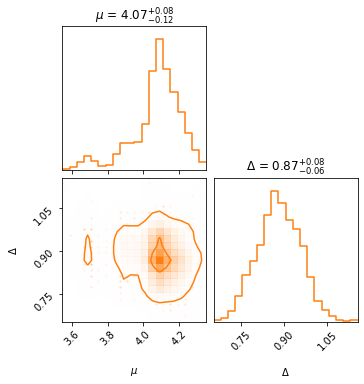

In [332]:
corner.corner(samples, bins=20, smooth=True, smooth1d=True, labels=[r'$\mu$',r'$\Delta$'], show_titles=True, levels=[0.16, 0.84], color='C1');

SRT: very good!

9.

In [360]:
import numdifftools as nd

f_lnlaplace = lambda params: np.sum(laplace.logpdf(obs, loc=params[0], scale=params[1]))

In [364]:
H = nd.Hessian(f_lnlaplace)([max_mu_a, max_delta_a])
sigma_laplace = np.linalg.inv(-H)**0.5 # hessian should have negative sign

<ipython-input-364-847800b277e9>:2: RuntimeWarning: invalid value encountered in sqrt
  sigma_laplace = np.linalg.inv(-H)**0.5


In [383]:
fisher = np.diag(sigma_laplace)
print(f'Fisher estimate on mu: {fisher[0]:.3f}\n(This is the same as the standard error on the sample mean we first calculated!)')
print(f'Std dev on bootstrap mu distribution: {np.std(bf_mu):.3f}')
print(f'\nFisher estimate on Delta: {fisher[1]:.3f}')
print(f'Std dev on bootstrap Delta distribution: {np.std(bf_delta):.3f}')

Fisher estimate on mu: 0.094
(This is the same as the standard error on the sample mean we first calculated!)
Std dev on bootstrap mu distribution: 0.135

Fisher estimate on Delta: 0.087
Std dev on bootstrap Delta distribution: 0.072


SRT: Excellent.